# Dask

## Distributed computation in Python _à la Spark_

<img src="img/dask.svg" width="300px" />

### Juan Luis Cano Rodríguez <hello@juanlu.space>
### Mission Planning & Execution Engineer @ Satellogic
### Data Night 2020-11-12 @ IE Big Data & AI Club

# Who am I?

<img src="img/yo.jpg" style="margin: inherit auto;" width="400px" />

* **Aeronautical Engineer** and self-taught pythonista
* **Mission Planning & Execution Engineer** at **Satellogic**
* **Former chair of Python España non-profit 🐍 🇪🇸** and former co-organizer of **PyConES**
* **Core developer** of Astropy, **lead developer** of poliastro, and **contributor** to other **Scientific Python** projects: NumPy, SciPy, conda, memory-profiler...
* **Adjunct professor** of Python for Statistical Programming and Advanced Python at **IE**
* Food & hard rock lover 🤘

# Resumen

<ol>
<li>State of the nation</li>
<li>Dask
<ol>
  <li>Intro</li>
  <li>Lazy evaluation</li>
  <li>Graphs of operations</li>
  <li>Demo</li>
  <li>Limitations</li>
</ol></li>
<li>Related projects</li>
<li>Conclusions &amp; future</li>
</ol>

# 1. State of the nation

**Your laptop: ~3.6 GHz**

![Clock speed](img/clock.jpg)

https://en.wikipedia.org/wiki/File:Clock_CPU_Scaling.jpg

![Big Data](img/bigdata.png)

<img src="img/cpus.gif" style="margin: inherit auto;" />

# 2. Dask

Dask is a flexible library for parallel computing in Python. It's composed of two parts:

<img src="img/dask.svg" width="300px" />

1. **Dynamic task scheduling** optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.
2. **"Big Data" collections** like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.


![dask](https://docs.dask.org/en/latest/_images/dask-overview.svg)

## Instalación

To install the most recent version (2.30.0, one month ago!)

```
$ python -m pip install "dask[complete]"
```

o con conda:

```
$ conda install dask
```

## Lazy evaluation

In [1]:
import numpy as np
import dask.array as da

In [2]:
x = np.arange(1000)
y = da.from_array(x, chunks=100)

In [3]:
y

dask.array<array, shape=(1000,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

If we try to perform any operation on these arrays, they don't execute immediately:

In [4]:
op = y.mean()
op

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

Dask is instead building a graph of operations:

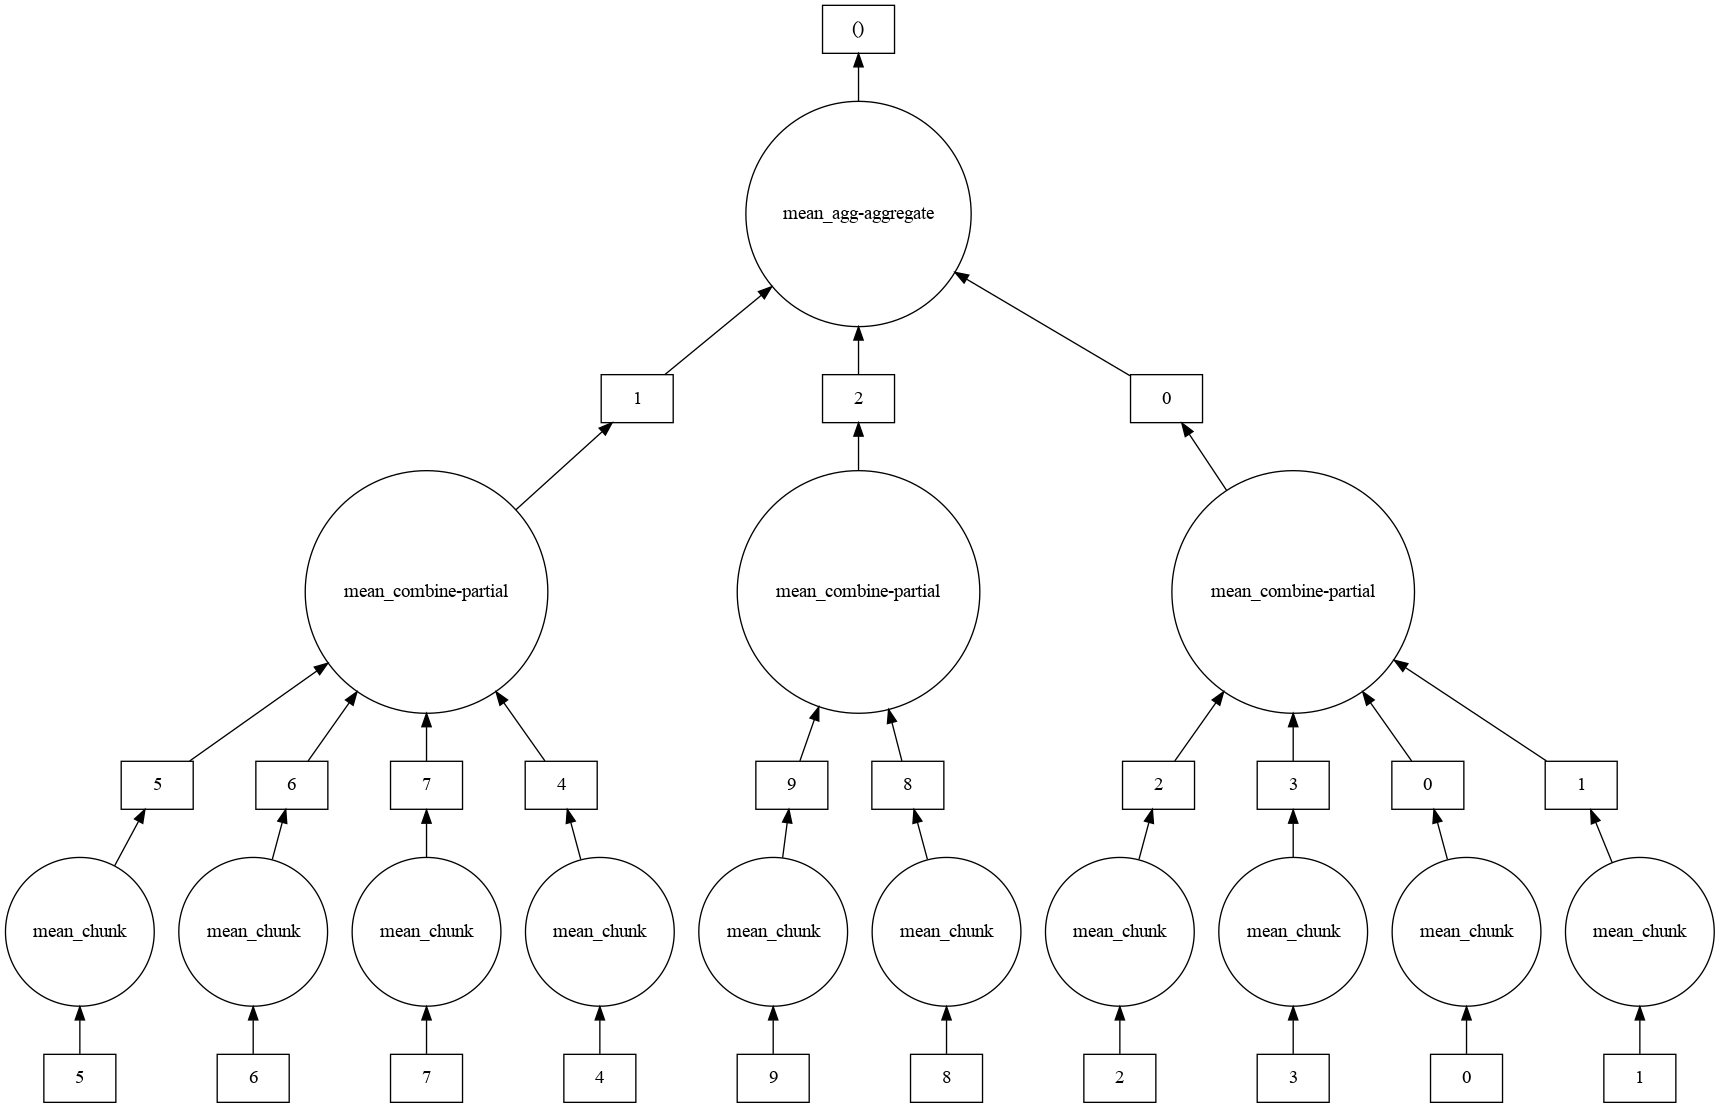

In [5]:
op.visualize()

If we want to actually execute the operation, we have to call `.compute()`:

In [6]:
op.compute()

499.5

In [7]:
y.compute()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Demo: NYC taxis

<img src="img/dask-dataframe.svg" width="300px" />

In [8]:
!cat data/raw_data_urls.txt

https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-02.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-03.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-04.csv


In [9]:
!du data/yellow*.csv -h -s

656M	data/yellow_tripdata_2019-01.csv
620M	data/yellow_tripdata_2019-02.csv
693M	data/yellow_tripdata_2019-03.csv
658M	data/yellow_tripdata_2019-04.csv


In [10]:
!du data/ -h -s

2,6G	data/


In [11]:
!cat data/download_raw_data.sh

cat raw_data_urls.txt | xargs -n 1 -P 6 wget -c -P .


Let's import `dask.dataframe`, which mimics `pandas.DataFrame`, and the distributed `Client`:

In [15]:
import dask.dataframe as dd

In [16]:
from dask.distributed import Client

client = Client()
client

/home/juanlu/.pyenv/versions/3.8.3/envs/dask38/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44469 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41179 Dashboard: http://127.0.0.1:44469/status,Cluster Workers: 4 Cores: 4 Memory: 16.70 GB


In [17]:
df = dd.read_csv(
    "data/yellow*.csv", parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"]
)

In [18]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [19]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

Vamos a calcular la longitud del DataFrame:

In [20]:
# Esta operación bloquea el intérprete durante unos minutos
len(df)

29952851

Also asynchronous:

In [24]:
futures = client.submit(len, df)
futures

<Future: finished, type: builtins.int, key: len-3872a42e601d36b21de6b7c27b54bf87>

In [25]:
from distributed import progress

In [26]:
progress(futures)

VBox()

In [27]:
op = df.groupby(df.passenger_count).trip_distance.mean()
op

Dask Series Structure:
npartitions=1
    float64
        ...
Name: trip_distance, dtype: float64
Dask Name: truediv, 150 tasks

In [28]:
f2 = client.compute(op)
f2

<Future: pending, key: finalize-de10df02b359ec8a3f202c3ceeb954b6>

In [29]:
progress(f2)

VBox()

In [30]:
f2.result()

passenger_count
0    2.788861
1    2.894872
2    3.009092
3    2.970344
4    3.015722
5    2.959904
6    2.934012
7    2.186186
8    5.187980
9    3.607727
Name: trip_distance, dtype: float64

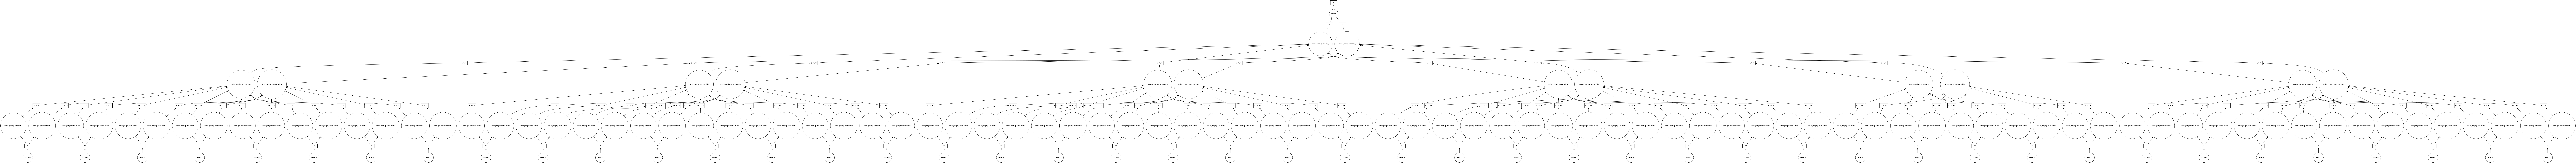

In [31]:
op.visualize()

In [32]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]    # filter out bad rows
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount  # make new column

In [33]:
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()
hour

Dask Series Structure:
npartitions=1
    float64
        ...
Name: tip_fraction, dtype: float64
Dask Name: truediv, 690 tasks

In [34]:
f_hour = client.compute(hour)

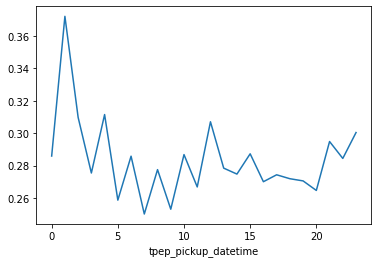

In [35]:
f_hour.result().plot();

In [36]:
import pandas as pd

In [37]:
payments = pd.DataFrame(
    {
        1: 'Credit Card',
        2: 'Cash',
        3: 'No Charge',
        4: 'Dispute',
        5: 'Unknown',
        6: 'Voided trip'
    }, index=["payment_name"]
).T

In [38]:
df2 = df.merge(payments, left_on='payment_type', right_index=True)

In [39]:
client.compute(df2.groupby(df2.payment_name).tip_amount.mean()).result()

payment_name
Cash           0.000358
Credit Card    2.896196
Dispute       -0.006623
No Charge      0.968446
Unknown        0.000000
Name: tip_amount, dtype: float64

## Limitations

Not all operations can be performed _without_ reading all the data in memory!

In [40]:
zero_tip = df2.tip_amount == 0
cash     = df2.payment_name == 'Cash'

client.compute(dd.concat([zero_tip, cash], axis=1).corr()).result()

/home/juanlu/.pyenv/versions/3.8.3/envs/dask38/lib/python3.8/site-packages/dask/dataframe/multi.py:1093: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


,tip_amount,payment_name
tip_amount,1.000000,0.911077
payment_name,0.911077,1.000000


What does this warning mean? In Dask, some operations are sensitive to **partitioning** http://dask.pydata.org/en/latest/dataframe-design.html#partitions so we'd had to `reindex` so they are all aligned.

If we don't, then this might happen:

In [41]:
df2.passenger_count.resample('1d').compute()

ValueError: Can only resample dataframes with known divisions
See https://docs.dask.org/en/latest/dataframe-design.html#partitions
for more information.

In [42]:
df2.npartitions

45

In [43]:
df2.divisions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [44]:
df3 = df2.set_index('tpep_pickup_datetime')

In [45]:
df3.npartitions

45

In [46]:
df3.divisions

(Timestamp('2001-02-02 14:55:07'),
 Timestamp('2019-01-01 11:13:38.257142784'),
 Timestamp('2019-01-04 20:22:47'),
 Timestamp('2019-01-08 00:30:59.685714176'),
 Timestamp('2019-01-10 18:53:06'),
 Timestamp('2019-01-12 23:42:25'),
 Timestamp('2019-01-15 21:46:36.400000'),
 Timestamp('2019-01-18 11:35:22.885714432'),
 Timestamp('2019-01-21 14:58:21'),
 Timestamp('2019-01-24 07:36:19.357143040'),
 Timestamp('2019-01-26 15:33:13'),
 Timestamp('2019-01-29 13:51:21'),
 Timestamp('2019-01-31 22:15:22'),
 Timestamp('2019-02-03 09:18:32'),
 Timestamp('2019-02-06 08:29:23'),
 Timestamp('2019-02-08 14:07:35'),
 Timestamp('2019-02-11 12:03:32'),
 Timestamp('2019-02-14 06:31:57'),
 Timestamp('2019-02-16 19:17:53'),
 Timestamp('2019-02-19 19:09:59'),
 Timestamp('2019-02-22 18:03:00'),
 Timestamp('2019-02-25 11:39:48'),
 Timestamp('2019-02-28 07:21:55.571428608'),
 Timestamp('2019-03-02 16:25:56'),
 Timestamp('2019-03-05 15:34:53'),
 Timestamp('2019-03-07 20:27:53.461721088'),
 Timestamp('2019-03-10 

<div class="alert alert-warning">Las operaciones que requieren reordenar el dataset tienen consideraciones de rendimiento especiales y pueden no ser aptas para realizarse en local.</div>

In [47]:
daily_mean = df3.passenger_count.resample('1d').mean()
daily_mean

Dask Series Structure:
npartitions=45
2001-02-02    int64
2019-01-01      ...
              ...  
2019-04-29      ...
2088-01-24      ...
Name: passenger_count, dtype: int64
Dask Name: resample, 1521 tasks

In [48]:
# Don't execute locally!!
# daily_mean.compute().plot()

# 3. Proyectos relacionados

The Dask ecosystem is growing really quickly:

- Linear Generalized Models https://github.com/dask/dask-glm
- Distributed Machine Learning https://github.com/dask/dask-ml
  - Distributed XGBoost training https://github.com/dask/dask-xgboost
- Dask + CUDA (GPU!) https://github.com/rapidsai/dask-cuda
- Workflow management https://github.com/PrefectHQ/prefect
- Massive scale Geoscience http://pangeo.io/

# 4. Conclusions

* Dask has some **advantages**:
  - Trivial to install
  - Familiar for NumPy and pandas users
  - Same workflow when scaling out
* And some limitations:
  - Smaller community (but growing!)
  - Not a silver bullet (sometimes you _need_ to scale out!)
  - Won't help scaling up (check out `numba` for that!)
  - Some overhead for massive workflows

## Some links

  - Documentation https://docs.dask.org/
  - Technical blog https://blog.dask.org/

<img src="img/mind.gif" style="margin: inherit auto;" width="400px" />
  
# `>>> print("Thank you!")`

### hello@juanlu.space